# PRMT-1984 [HYPOTHESIS] The spread of EMIS-EMIS pending (without error) transfers is even across GP Practices

NB: Could this be extended to Integrated Late??

### Hypothesis
We believe that EMIS-EMIS pending transfers are spread evenly across practices
We will know this to be true when we see in the data that for these transfers, they are consistently spread cross the majority of practices rather than clustered in a smaller group of practices

 

### Subsequent questions (later hypotheses)

If transfers are in a cluster of smaller practices, what do the integrations look like for those practices? I.e. are they bad at integration and therefore makes sense that they have poor pending?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet"
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
# This is only needed when using transfers-duplicates-hypothesis datasets
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)

In [3]:
asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)

In [4]:
# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(lambda x: True in [(np.isnan(i) or i==15) for i in x])
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

In [5]:
transfers.loc[transfers['status']=='FAILED','sla_duration'].dropna()

59            196.0
99           7889.0
109       2241598.0
136            99.0
155            93.0
            ...    
234091          2.0
234281          3.0
234289          3.0
234372         58.0
234525          1.0
Name: sla_duration, Length: 22771, dtype: float64

In [6]:
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

In [7]:
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'

In [8]:
twenty_eight_days_in_seconds=28*24*60*60
transfers_after_month_bool=transfers['sla_duration']>twenty_eight_days_in_seconds
transfers_pending_at_month_bool=transfers_after_month_bool & transfers_integrated_late_bool
transfers.loc[transfers_pending_at_month_bool,'status']='PENDING'
transfers_with_early_error_bool=(~transfers.loc[:,'sender_error_code'].isna()) |(~transfers.loc[:,'intermediate_error_codes'].apply(len)>0)
transfers.loc[transfers_with_early_error_bool & transfers_pending_at_month_bool,'status']='PENDING_WITH_ERROR'

In [9]:
# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

lookup = asid_lookup[["ASID", "MName", "NACS"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left').drop("NACS", axis=1)
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

### Select just relevant data: EMIS-EMIS

In [10]:
both_suppliers_EMIS_bool=(transfers['requesting_supplier']=='EMIS') & (transfers['sending_supplier']=='EMIS')

relevant_transfers=transfers.loc[both_suppliers_EMIS_bool]

In [101]:
emis_emis_status_table=relevant_transfers['status'].value_counts()

emis_emis_status_table_pc=(100*emis_emis_status_table/emis_emis_status_table.sum()).round(2)

pd.concat([emis_emis_status_table.rename('Volume'),emis_emis_status_table_pc.rename('%')],axis=1)

,Volume,%
INTEGRATED,718274,91.15
INTEGRATED LATE,43210,5.48
PENDING,16353,2.08
FAILED,8159,1.04
PENDING_WITH_ERROR,2023,0.26


### Pivot table of practice vs status volumes

In [11]:
practice_status_table=pd.pivot_table(relevant_transfers,index='requesting_practice_asid',columns='status',values='conversation_id',aggfunc='count').fillna(0)
practice_status_table['TOTAL']=practice_status_table.sum(axis=1)
practice_status_pc=100*practice_status_table.div(practice_status_table['TOTAL'],axis=0).drop('TOTAL',axis=1)
practice_status_pc.columns=practice_status_pc.columns + " %"
practice_status_pc=practice_status_pc.round(2)
practice_status_table=pd.concat([practice_status_table,practice_status_pc],axis=1)
print(practice_status_table.shape[0])
print(practice_status_table['PENDING %'].median())
print(practice_status_table['PENDING %'].mean())

3955
0.33
3.1724096080910233


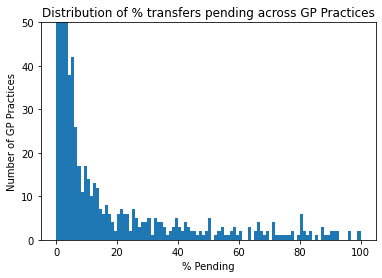

In [12]:
ax =practice_status_table['PENDING %'].plot.hist(bins=range(101),ylim=[0,50])
ax.set_xlabel('% Pending')
ax.set_ylabel('Number of GP Practices')
ax.set_title('Distribution of % transfers pending across GP Practices')
practice_status_table['PENDING %'].quantile(np.arange(0.1, 1.1, 0.1))
plt.gcf().savefig('EMIS_EMIS_pending_distribution.png')

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING %'>

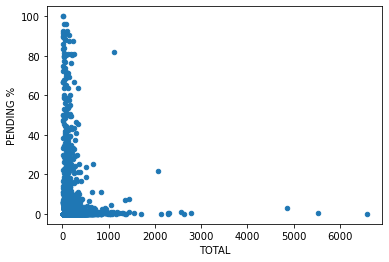

In [13]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING %')

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING %'>

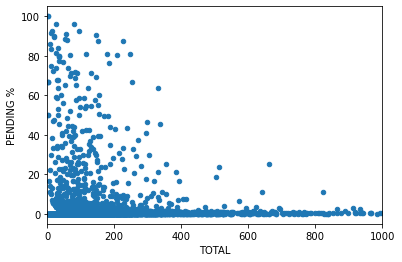

In [14]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING %',xlim=[0,1000])

<AxesSubplot:xlabel='PENDING %', ylabel='INTEGRATED LATE %'>

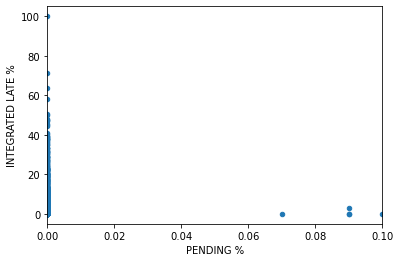

In [15]:
practice_status_table.plot.scatter(x='PENDING %',y='INTEGRATED LATE %',xlim=[0,0.1])

In [16]:
practice_status_table[["FAILED %","INTEGRATED %","INTEGRATED LATE %","PENDING %","PENDING_WITH_ERROR %"]].corr().round(2)

status,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
status,,,,,
FAILED %,1.00,-0.41,0.06,0.36,-0.00
INTEGRATED %,-0.41,1.00,-0.74,-0.80,-0.09
INTEGRATED LATE %,0.06,-0.74,1.00,0.23,-0.00
PENDING %,0.36,-0.80,0.23,1.00,0.01
PENDING_WITH_ERROR %,-0.00,-0.09,-0.00,0.01,1.00


<AxesSubplot:xlabel='PENDING %', ylabel='FAILED %'>

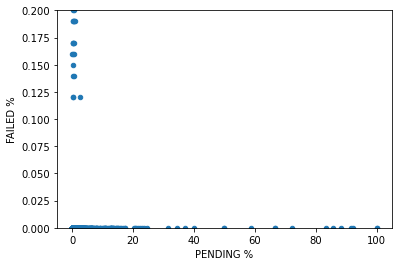

In [17]:
practice_status_table.plot.scatter(x='PENDING %',y='FAILED %',ylim=[0,0.2])

<AxesSubplot:xlabel='TOTAL', ylabel='PENDING'>

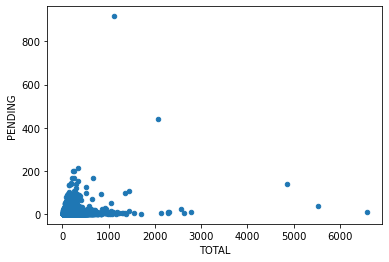

In [18]:
practice_status_table.plot.scatter(x='TOTAL',y='PENDING')

In [19]:
practice_status_table.corr()

status,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
status,,,,,,,,,,,
FAILED,1.000000,0.312707,0.587494,0.441363,0.317940,0.486602,0.320491,-0.167851,0.056411,0.141826,-0.006331
INTEGRATED,0.312707,1.000000,0.139091,0.008456,0.595107,0.960091,-0.059742,0.201421,-0.165714,-0.150830,-0.020778
INTEGRATED LATE,0.587494,0.139091,1.000000,0.246875,0.290396,0.394733,0.029487,-0.242526,0.352154,0.047018,-0.002643
PENDING,0.441363,0.008456,0.246875,1.000000,0.088071,0.161879,0.204845,-0.454847,0.166755,0.532747,0.002453
PENDING_WITH_ERROR,0.317940,0.595107,0.290396,0.088071,1.000000,0.632030,-0.009932,0.015052,-0.020169,-0.029302,0.179392
TOTAL,0.486602,0.960091,0.394733,0.161879,0.632030,1.000000,-0.022222,0.085753,-0.055400,-0.078327,-0.018934
FAILED %,0.320491,-0.059742,0.029487,0.204845,-0.009932,-0.022222,1.000000,-0.408119,0.059399,0.363831,-0.000351
INTEGRATED %,-0.167851,0.201421,-0.242526,-0.454847,0.015052,0.085753,-0.408119,1.000000,-0.743061,-0.800451,-0.093574
INTEGRATED LATE %,0.056411,-0.165714,0.352154,0.166755,-0.020169,-0.055400,0.059399,-0.743061,1.000000,0.228225,-0.003299


In [20]:
practice_status_table['PENDING'].max()/practice_status_table['PENDING'].sum()

0.056075337858496915

In [21]:
practice_status_table=practice_status_table.sort_values(by='PENDING',ascending=False)
full_practice_status_table=asid_lookup.merge(practice_status_table, left_on='ASID', right_index=True, how='right')
full_practice_status_table=full_practice_status_table.drop(['MName','PName'],axis=1)
full_practice_status_table.head()


,ASID,NACS,OrgName,OrgType,PostCode,FAILED,INTEGRATED,INTEGRATED LATE,PENDING,PENDING_WITH_ERROR,TOTAL,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
33038,615075629043,D82088,UEA MEDICAL CENTRE,GP Practice,NR4 7TJ,123.0,36.0,40.0,917.0,1.0,1117.0,11.01,3.22,3.58,82.09,0.09
33754,669024222046,P81002,LANCASTER MEDICAL PRACTICE,GP Practice,LA1 1PN,47.0,755.0,815.0,442.0,1.0,2060.0,2.28,36.65,39.56,21.46,0.05
28125,260198413015,G82074,BEARSTED,GP Practice,ME14 4DS,44.0,73.0,2.0,211.0,0.0,330.0,13.33,22.12,0.61,63.94,0.00
38052,994133653042,F86008,GANTS HILL MEDICAL CENTRE,GP Practice,IG2 6UP,16.0,10.0,19.0,201.0,2.0,248.0,6.45,4.03,7.66,81.05,0.81
31980,540917834041,K81638,BURMA HILL PRACTICE,GP Practice,RG40 1PH,26.0,1.0,0.0,199.0,1.0,227.0,11.45,0.44,0.00,87.67,0.44


In [22]:
def generate_gp_table(gp_asid): 
    gp_practice_transfers=transfers.loc[transfers['requesting_practice_asid']==gp_asid].copy()
    gp_practice_transfers.loc[:,'Month']=gp_practice_transfers['date_requested'].copy().dt.to_period('M')

    gp_totals=pd.pivot_table(gp_practice_transfers,index='Month',columns='status',values='conversation_id',aggfunc='count').fillna(0)
    gp_percentages=pd.pivot_table(gp_practice_transfers,index='Month',columns='status',values='conversation_id',aggfunc='count').fillna(0).div(gp_practice_transfers['Month'].value_counts(),axis=0)
    gp_percentages=(100*gp_percentages).round(2)
    gp_percentages.columns='% '+gp_percentages.columns

    return pd.concat([gp_totals, gp_percentages], axis=1)



# Break down by user profile: 

## Ie is the issue related to a handful of practices or distributed?

Consider for each practice, it's total number of transfers, it's outcomes 

- Rank practices by the total number of issues (eg Pending)
- Break into quantiles based on number of issues
- Identify what % of users and what % of total transfers each quantile represents

In [24]:
practice_profile_data=practice_status_table.copy()

cumulative_percentage=practice_status_table['PENDING'].cumsum()/practice_status_table['PENDING'].sum()
quantiles=5
practice_profile_data['Quantile Group']=np.ceil(cumulative_percentage*quantiles)

practice_profile_data=practice_profile_data.groupby('Quantile Group').agg({'PENDING':'sum','TOTAL':'sum','INTEGRATED':'count'}).astype(int)
practice_profile_data=practice_profile_data.rename({'PENDING':'Total Pending','TOTAL':'Total Transfers','INTEGRATED':'Total Practices'},axis=1)

practice_profile_data_percentages=(100*practice_profile_data/practice_profile_data.sum()).round(2)
practice_profile_data_percentages.columns= "% " + practice_profile_data_percentages.columns

practice_profile_table=pd.concat([practice_profile_data,practice_profile_data_percentages],axis=1)
practice_profile_table

,Total Pending,Total Transfers,Total Practices,% Total Pending,% Total Transfers,% Total Practices
Quantile Group,,,,,,
1.0,3186,10960,13,19.48,1.39,0.33
2.0,3352,11821,38,20.50,1.50,0.96
3.0,3263,18536,78,19.95,2.35,1.97
4.0,3281,71228,259,20.06,9.04,6.55
5.0,3271,675474,3567,20.00,85.72,90.19


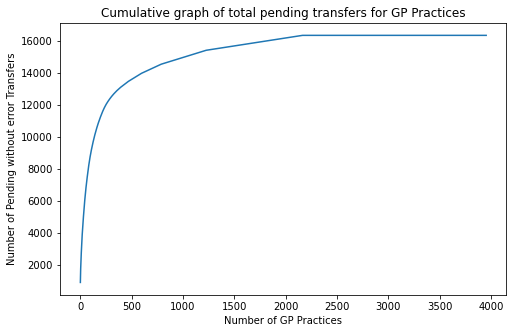

In [92]:
ax=practice_status_table['PENDING'].cumsum().reset_index(drop=True).plot(figsize=(8,5))
ax.set_ylabel('Number of Pending without error Transfers')
ax.set_xlabel('Number of GP Practices')
ax.set_title('Cumulative graph of total pending transfers for GP Practices')
plt.gcf().savefig('EMIS_EMIS_cumulative_pending_transfers.jpg')

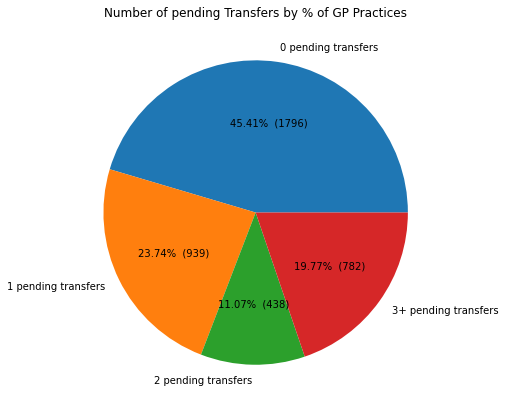

In [91]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

practices_by_total_pending=practice_status_table['PENDING'].value_counts()
practices_by_total_pending.index=practices_by_total_pending.index.astype(int)


reduced_df=practices_by_total_pending.head(3)
reduced_df['3+']=practices_by_total_pending.tail(-3).sum()
reduced_df.index=reduced_df.index.astype(str) + ' pending transfers'
practices_by_total_pending=reduced_df

#practices_by_total_pending.plot.pie(autopct=make_autopct(values))

plt.pie(practices_by_total_pending.values, labels=practices_by_total_pending.index, autopct=make_autopct(practices_by_total_pending.values))
plt.gcf().set_size_inches(7,7)
plt.gca().set_title('Number of pending Transfers by % of GP Practices')
#plt.show()
plt.gcf().savefig('EMIS_EMIS_pie_number_pending_pc_practices.jpg')

0     1796
1      939
2      438
3+     782
Name: PENDING, dtype: int64

# Output to Excel

In [27]:
writer = pd.ExcelWriter('prmt-1984-emis-emis-practice-level-statuses.xlsx', engine='xlsxwriter')

practice_profile_table.to_excel(writer, sheet_name='Breakdown')
full_practice_status_table.to_excel(writer, sheet_name='Overview')

asid_of_interest=full_practice_status_table.head(10)['ASID'].values
[generate_gp_table(gp_asid).to_excel(writer,sheet_name=gp_asid) for gp_asid in asid_of_interest] 

writer.save()